In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
from scipy.spatial import distance
from sys import stdout

def labelled_mesh(x_samples, y_samples, labels_samples, dict_samples, x_mesh, y_mesh, dmax=500, search=True):
    
    import time
    
    size = x_mesh.size
    tic = time.time()
    labels = np.zeros((size, 1)) 

    c = 1
    for xp, yp, lb in zip(x_samples, y_samples, labels_samples):

        percentage = c/x_samples.size
        time_msg = "\rRunning Progress at {0:.2%} ".format(percentage)
        stdout.write(time_msg)

        dists = np.ones((size,)) * 99999

        j = 0
        for xm, ym in zip(x_mesh.ravel(), y_mesh.ravel()):

            # search area
            if search:

                if(xm-dmax <= xp <= xm+dmax) and (ym-dmax <= yp <= ym+dmax):

                    dists[j] = distance.euclidean((xp, yp), (xm, ym))
                else:
                    dists[j] = 99999

                j += 1
            
            else:
                dists[j] = distance.euclidean((xp, yp), (xm, ym))
                j += 1

        if dists.min() <= dmax:
            if len(lb) > 0:
                labels[np.argmin(dists)] = int(dict_samples[lb])
            else:
                labels[np.argmin(dists)] = int(0)
        c += 1


    labels = labels.reshape(x_mesh.shape[0], x_mesh.shape[1])
    toc = time.time()
    
    print(f'| Processing time: {(toc-tic)/60:.4f}min')
    
    return labels

In [3]:
def calc_dist(ds, gdf, xdim='lon', ydim='lat', n=1000, set_random=True):

    import warnings
    from numpy.random import choice
    from numpy import concatenate
    from scipy.interpolate import griddata
    from scipy.spatial.distance import euclidean
    from tqdm.notebook import tqdm
    import time
    from sys import stdout
    warnings.simplefilter("ignore", UserWarning)
    
    tic = time.time()
    x = ds[xdim].data
    y = ds[ydim].data
    ny, nx = ds.dims['y'], ds.dims['x']
    print((ny, nx))
     

    if set_random:
        index = np.arange(0, y.size, 1, dtype=int)
        sy = sx = choice(index, size=int(n*.8), replace=False)
    
    else:
        sy = sx = np.arange(0, y.size, int(n*.8), dtype=int)
    
    yborder = np.linspace(0, ny-1, n//20, dtype=int)
    xborder = np.linspace(0, nx-1, n//20, dtype=int)
    xi = concatenate([x.ravel()[sx], x[0, :][xborder], x[-1, :][xborder],
                      x[:, 0][yborder], x[:,-1][yborder]])
    yi = concatenate([y.ravel()[sy], y[0, :][xborder], y[-1, :][xborder],
                      y[:, 0][yborder], y[:, -1][yborder]])
    
    # create buffer array
    buffer = np.empty(xi.size)
    
    # gdf x, y coordinates
    xp = gdf.geometry.x.values
    yp = gdf.geometry.y.values
    
    c = 0
    for x_i, y_i in zip(xi, yi):
        
        percentage = c/n
        time_msg = "\rRunning Progress at {0:.0%} ".format(percentage)
        stdout.write(time_msg)
        # store distances
        dist = []
        for x_p, y_p in zip(xp, yp):
    
            dist.append(euclidean((x_i, y_i), (x_p, y_p)))
        
        # add min distance to array
        buffer[c] = np.min(dist)
        c += 1
    
    # interp
    buffer = griddata((xi, yi), buffer, (x, y), method='linear')
    buffer = np.nan_to_num(buffer, nan=np.nanmean(buffer))
    toc = time.time()
    
    print(f'\n Processing Time: {(toc-tic)/60} min.')
    return buffer

#### Set directory

In [4]:
os.chdir("/home/silva/Research/Alta-Floresta/")

### Import data

In [5]:
dset = xarray.open_dataset('DATASETS/dset_AF.nc')
dset 

<xarray.Dataset>
Dimensions:  (y: 1335, x: 1322)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 ...
    Kperc    (y, x) float64 ...
    eTh      (y, x) float64 ...
    eU       (y, x) float64 ...
    resmag   (y, x) float64 ...
    asa      (y, x) float64 ...
    tilt     (y, x) float64 ...
    DTM      (y, x) float64 ...
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

### Import lithologies

In [6]:
lithos = gpd.read_file('Juruena_Teles_Pires_Mapa_Integrado/Litologia/Juruena_Teles_Pires_Lito.shp')
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
lithos.to_crs(crs, inplace=True)
lithos.head()

,COD_UNI_ES,SIGLA_UNID,NOME_UNIDA,SIGLAS_ANT,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,PERIODO_MA,...,ERRO_PRESS,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,geometry
0,3207,MP2d2,Dardanelos - Fácies 2,None,Fácies,1400.0,0.0,Proterozóico,Mesoproterozóico,Ectasiano,...,None,None,None,None,"Arenito arcoseano, Arenito",None,Sedimentar,None,Clástica,"POLYGON ((-55.07166 -11.00000, -55.07169 -11.0..."
1,643,N1r,Ronuro,N1a,Formação,23.5,0.0,Fanerozóico,Cenozóico,Neogeno,...,None,None,None,None,"Cascalho, Argila, Areia",None,Material superficial,None,Sedimento inconsolidado,"POLYGON ((-54.23781 -10.72836, -54.23924 -10.7..."
2,1360,PP34mvbm,Complexo Nova Monte Verde - Unidade Bacaeri-Mogno,PP23bm,Unidade,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,0,Média P/T,Não determinada,None,"Metachert, Paragnaisse, Rocha calcissilicática...",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.91694 -9.87497, -56.91692 -9.875..."
3,2977,PP34mvvpe,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(end),Fácies,2243.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,None,Não determinado,Não determinada,None,"Quartzo diorito, Enderbito",None,Ígnea,None,Plutônica,"POLYGON ((-56.63942 -9.98401, -56.64000 -9.985..."
4,2970,PP34mvvpa,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(af),Fácies,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,None,None,None,None,"Metapiroxenito, Metanorito, Metagabro",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.86034 -9.98801, -56.86029 -9.988..."


In [7]:
print(lithos.columns)

Index(['COD_UNI_ES', 'SIGLA_UNID', 'NOME_UNIDA', 'SIGLAS_ANT', 'HIERARQUIA',
       'IDADE_MAX', 'ERRO_MAX', 'EON_IDAD_M', 'ERA_MAXIMA', 'PERIODO_MA',
       'EPOCA_MAX', 'SISTEMA_GE', 'METODO_GEO', 'QLDE_INFER', 'IDADE_MIN',
       'ERRO_MIN', 'EON_IDAD_1', 'ERA_MINIMA', 'PERIODO_MI', 'EPOCA_MIN',
       'SISTEMA__1', 'METODO_G_1', 'QLDE_INF_1', 'AMBSEDIMEN', 'SISTSEDIME',
       'TIPO_DEPOS', 'ASSOC_MAGM', 'NIVEL_CRUS', 'TEXTURA_IG', 'FONTE_MAGM',
       'MORFOLOGIA', 'AMBIENTE_T', 'METAMORFIS', 'METODO_G_2', 'TEMP_PICO',
       'ERRO_TEMP_', 'PRESSAO_PI', 'ERRO_PRESS', 'TIPO_BARIC', 'TRAJETORIA',
       'LITOTIPO1', 'LITOTIPO2', 'CLASSE_ROC', 'CLASSE_R_1', 'BB_SUBCLAS',
       'BB_SUBCL_1', 'geometry'],
      dtype='object')


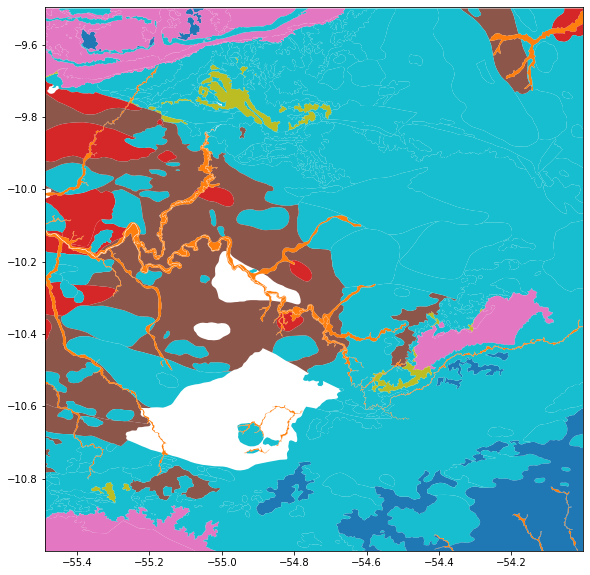

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
lithos.plot(ax=ax, column='CLASSE_R_1')
ax.set_xlim(dset['lon'].data.min(), dset['lon'].data.max())
ax.set_ylim(dset['lat'].data.min(), dset['lat'].data.max())
ax.set_aspect(1)
plt.show()

In [9]:
classes = lithos.CLASSE_R_1.unique()

lithos[lithos.CLASSE_R_1 == classes[0]].NOME_UNIDA.unique()

array(['Dardanelos - Fácies 2', 'Beneficente - Unidade 1',
       'Beneficente - Unidade 2', 'Beneficente - Unidade 3',
       'Rio das Pombas', 'Araúna', 'Serra Estreita', 'Três Quedas',
       'Igarapé Ipixuna', 'São Manoel', 'Dardanelos - Fácies 3',
       'Dardanelos - Fácies 1'], dtype=object)

In [10]:
lithos.SIGLA_UNID.unique()

array(['MP2d2', 'N1r', 'PP34mvbm', 'PP34mvvpe', 'PP34mvvpa', 'PP34mvvp',
       'MP23b1', 'MP23b2', 'PP34_gamma_tp', 'MP23b3', 'SDrp', 'N1dl',
       'PP3_gamma_gtn', 'PP3_gamma_pqp', 'PP34_alfa_cbj', 'PP34_alfa_cbn',
       'PP34_alfa_cbsf', 'PP34_alfa_cbsq', 'PP3cc', 'PP4_gamma_tptn',
       'PP4_gamma_tphg', 'PP4_gamma_tphs', 'PP34_gamma_tpns',
       'PP34_gamma_tpnm', 'PP34_gamma_tprc', 'SDa', 'SDse', 'PP3_gamma_m',
       'PP3_gamma_mvr', 'PP3_gamma_mc', 'Q2a', 'PP3_delta_fs',
       'PP3_gamma_n', 'PP3_gamma_pq', 'SDtq', 'CPii', 'CPsm', 'MZdc',
       'PP4_delta_g', 'MP2d3', 'MP2d1', 'PP34_gamma_jpa', 'PP4_gamma_jsp',
       'PP4_gamma_jnc', 'PP3_gamma_msm', 'PP3_alfa_jn', 'PP3_gamma_mfb'],
      dtype=object)

### Add lithos to dataset

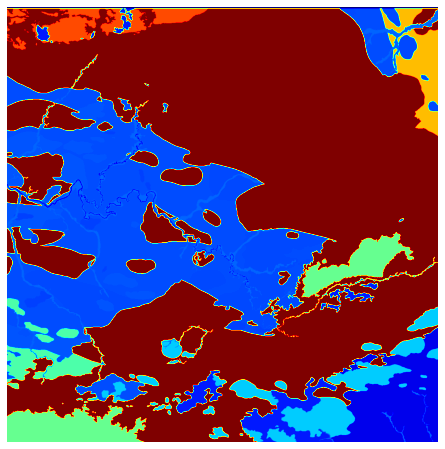

In [11]:
import rasterio
src = rasterio.open('RASTERS/litho_units.tif')
src_units = src.read(1)
# fill rivers with eluvial units
src_units = np.where(src_units == 0., 1507, src_units)
plt.figure(figsize=(8, 8))
plt.imshow(src.read(1), cmap='jet', aspect=1)
plt.axis('off')
plt.show()

In [12]:
# find units back for the entire dataset
sigla_units = lithos['SIGLA_UNID'].values
cod_units = np.unique(lithos['COD_UNI_ES'].values)
# ny, nx
ny, nx = dset.dims['y'], dset.dims['x']
units = np.array(np.zeros((ny, nx)), dtype='object')

for cod in cod_units:
    yx = np.where(src_units == cod)
    wh = np.where(lithos['COD_UNI_ES'].values == cod)[0]
    
    units[yx] = sigla_units[wh][0]

In [13]:
dset['litho_units'] =  (['y', 'x'], units, {'Description':'Eastern Alta Floresta Litho-Units'})
dset

<xarray.Dataset>
Dimensions:      (y: 1335, x: 1322)
Coordinates:
    lon          (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0 -54.0
    lat          (y, x) float64 -11.0 -11.0 -11.0 -11.0 ... -9.497 -9.497 -9.497
Dimensions without coordinates: y, x
Data variables:
    TC           (y, x) float64 ...
    Kperc        (y, x) float64 ...
    eTh          (y, x) float64 ...
    eU           (y, x) float64 ...
    resmag       (y, x) float64 ...
    asa          (y, x) float64 ...
    tilt         (y, x) float64 ...
    DTM          (y, x) float64 ...
    litho_units  (y, x) object 'Q2a' 'Q2a' 'Q2a' 'Q2a' ... 'N1r' 'N1r' 'N1r'
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [14]:
# save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF_2.nc', mode='w', format='NETCDF4')

#### Import bounds

In [15]:
bounds = gpd.read_file('VETORES/bounds.gpkg')
bounds.to_crs(crs)
bounds

,Presence,geometry
0,0,"POLYGON ((-55.48999 -11.00000, -54.00000 -11.0..."


#### Importing dataset with deposits and occurrences

In [23]:
dep_occ =\
gpd.read_file('Juruena_Teles_Pires_Mapa_Integrado/Ocorrencia Mineral/Juruena_Teles_Pires_Recmin.shp')#, bbox=bounds.geometry)
# add crs
dep_occ.to_crs(crs, inplace=True)
print(dep_occ.shape)
dep_occ.head()

(209, 27)


,TOPONIMIA,LATITUDE,LONGITUDE,SUBST_PRIN,ABREV,SUBS_SEC,FONTE_CADA,STATUS_ECO,GRAU_DE_IM,CLASSIFIC,...,ASSOC_GEOQ,ROCHA_ENCA,ROCHA_HOSP,TEXTURA_MI,TIPOS_ALTE,EXTRMIN_X,ASSOC_MINE,MUNICIPIO,UF,geometry
0,Bergão,-10.078066,-55.247903,Ouro,Au,None,CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Brecha hidrotermal,Granitoide,0.0,None,0.0,None,Novo Mundo,MT,POINT (-55.24790 -10.07807)
1,Buriti,-10.242700,-55.028989,Ouro,Au,None,CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Hidrotermalito clorítico cisalhado,Granitoide,0.0,Cloritização,0.0,Pirita,Matupá,MT,POINT (-55.02899 -10.24270)
2,Chico,-10.541099,-54.584110,Ouro,Au,"Ag, Pb, Zn, Cu",CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Brecha hidrotermal,Rochas vulcanoclásticas ácidas e epiclásticas,0.0,Sericitização,0.0,"Esfalerita, galena, bornita, pirita",União do Norte,MT,POINT (-54.58353 -10.53907)
3,Cidinha antigo aniceto,-10.248814,-55.013273,Ouro,Au,None,CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Granitoide silicificado,Granitoide,0.0,Cloritização,0.0,Pirita,Peixoto de Azevedo,MT,POINT (-55.01327 -10.24881)
4,Edu,-10.828704,-55.189177,Ouro,Au,Cu,CPRM 2015 (CA_FS),Depósito,Depósito,Primário,...,0.0,Filonito sericítico,Granitoide,0.0,Fílica,0.0,"Pirita, calcopitita",Nova Santa Helena,MT,POINT (-55.18918 -10.82870)


In [24]:
# select gold as primary element
primary = dep_occ[dep_occ.SUBST_PRIN == 'Ouro'].copy()
primary.reset_index(drop=True, inplace=True)
print(primary.shape)

(200, 27)


In [25]:
print('Genetic class:', primary.CLASSE_GEN.unique(), '\n Model:', primary.MODELO_DEP.unique())

Genetic class: ['Magmático-hidrotermal' 'Indeterminada'] 
 Model: ['Epitermal ou intrusion related' 'Epitermal (sulfetação intermediária)'
 None 'Epitermal (alta sulfetação)' 'Stockwork (intrusion related)'
 'Intrusion related ou Au pórfiro']


In [26]:
# select magmatic-hidrothermal classes
cond_1 = primary.CLASSE_GEN == 'Magmático-hidrotermal'
# select epithermal or intrusion related
cond_2 = primary.MODELO_DEP == 'Epitermal ou intrusion related'

mag_epithermal = primary[cond_1 | cond_2].copy()
mag_epithermal.reset_index(drop=True, inplace=True)
print(mag_epithermal.shape)
mag_epithermal.head(3)

(96, 27)


,TOPONIMIA,LATITUDE,LONGITUDE,SUBST_PRIN,ABREV,SUBS_SEC,FONTE_CADA,STATUS_ECO,GRAU_DE_IM,CLASSIFIC,...,ASSOC_GEOQ,ROCHA_ENCA,ROCHA_HOSP,TEXTURA_MI,TIPOS_ALTE,EXTRMIN_X,ASSOC_MINE,MUNICIPIO,UF,geometry
0,Bergão,-10.078066,-55.247903,Ouro,Au,None,CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Brecha hidrotermal,Granitoide,0.0,None,0.0,None,Novo Mundo,MT,POINT (-55.24790 -10.07807)
1,Buriti,-10.242700,-55.028989,Ouro,Au,None,CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Hidrotermalito clorítico cisalhado,Granitoide,0.0,Cloritização,0.0,Pirita,Matupá,MT,POINT (-55.02899 -10.24270)
2,Chico,-10.541099,-54.584110,Ouro,Au,"Ag, Pb, Zn, Cu",CPRM 2015 (CA_FS),Garimpo ativo,Ocorrência,Primário,...,0.0,Brecha hidrotermal,Rochas vulcanoclásticas ácidas e epiclásticas,0.0,Sericitização,0.0,"Esfalerita, galena, bornita, pirita",União do Norte,MT,POINT (-54.58353 -10.53907)


In [27]:
print(mag_epithermal.GRAU_DE_IM.unique())

['Ocorrência' 'Depósito' 'Garimpo']


In [28]:
mag_epithermal.to_file('VETORES/mag_hydrothermal.gpkg', 'GPKG')

/home/silva/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [21]:
pos_dict = {'Ocorrência':1, 'Depósito':2, 'Garimpo':3}
pos_dict

{'Ocorrência': 1, 'Depósito': 2, 'Garimpo': 3}

In [22]:
# positive examples mesh
pos_mesh = labelled_mesh(mag_epithermal.LONGITUDE.values, mag_epithermal.LATITUDE.values,
                         mag_epithermal.GRAU_DE_IM.values, pos_dict, 
                         dset['lon'].data, dset['lat'].data, dmax=250/111e3, search=True)

Running Progress at 100.00% | Processing time: 0.4912min


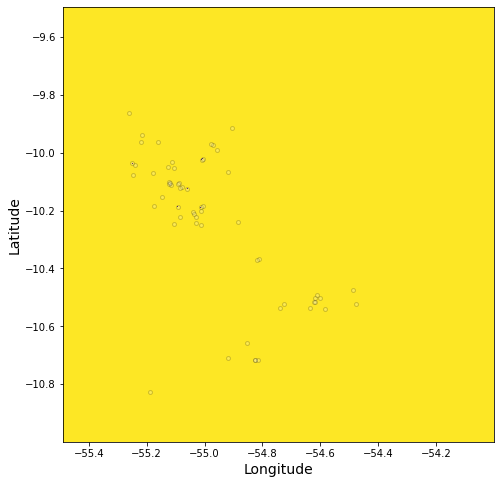

In [23]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='w')
ax.pcolormesh(dset['lon'].data, dset['lat'].data, np.where(pos_mesh > 0, 1, 0), shading='auto',
               vmin=0, vmax=1, cmap='viridis_r')
mag_epithermal.plot(ax=ax, color='w', edgecolor='k', alpha=0.2, markersize=15)
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('figs/dep_occ_locations.png', dpi=400, bbox_inches='tight')
plt.show()

In [24]:
dset['labels'] =  (['y', 'x'], pos_mesh, {'Absent':0, 'Occurrences':1, 'Deposits':2, 'Mining':3})
dset

<xarray.Dataset>
Dimensions:      (y: 1335, x: 1322)
Coordinates:
    lon          (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0 -54.0
    lat          (y, x) float64 -11.0 -11.0 -11.0 -11.0 ... -9.497 -9.497 -9.497
Dimensions without coordinates: y, x
Data variables:
    TC           (y, x) float64 ...
    Kperc        (y, x) float64 ...
    eTh          (y, x) float64 ...
    eU           (y, x) float64 ...
    resmag       (y, x) float64 ...
    asa          (y, x) float64 ...
    tilt         (y, x) float64 ...
    DTM          (y, x) float64 ...
    litho_units  (y, x) object 'Q2a' 'Q2a' 'Q2a' 'Q2a' ... 'N1r' 'N1r' 'N1r'
    labels       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

#### Compute log-probability of lithological units at positive locations

In [25]:
# occurrences
cond_occ = (dset['labels'].data == 1)
# deposits
cond_dep = (dset['labels'].data == 2)

# positions
pos_idy, pos_idx = np.where(cond_occ | cond_dep)

In [26]:
buffer_pos = calc_dist(dset, mag_epithermal[mag_epithermal.GRAU_DE_IM == 'Depósito'], n=50000)*111

(1335, 1322)
Running Progress at 100% 
 Processing Time: 0.07033633391062419 min.


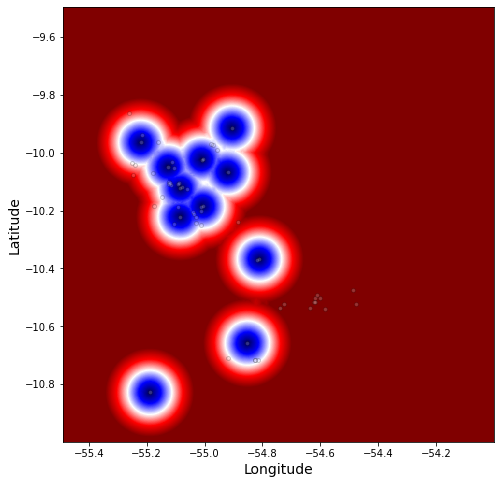

In [27]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='w')
ax.pcolormesh(dset['lon'].data, dset['lat'].data, buffer_pos, shading='auto',
               vmin=0, vmax=17, cmap='seismic')
mag_epithermal.plot(ax=ax, color='w', edgecolor='k', alpha=0.2, markersize=15)
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

In [28]:
pixel_size = 125 #[m]

def calc_SA(ds, var='litho_units', cond=cond_dep, pixel_size=pixel_size):
    # number of deposits per unit
    number_deps = []
    # units' names
    units = []
    # spatial association (SA)
    SAs = []

    # filter deposit locations
    dep_ids = np.where(cond)
    unique_units, counts = np.unique(np.flip(ds[var].data, axis=0)[dep_ids], return_counts=True)

    # add units with none deposits
    diff_unique = np.setdiff1d(np.unique(ds[var].data), unique_units)
    unique_units = np.concatenate((unique_units, diff_unique))
    counts = np.concatenate((counts, np.zeros(diff_unique.size)))

    # add unique and counts for the entire area
    all_uniques, total_counts = np.unique(ds[var].data, return_counts=True)

    # compute SA for all units in the study area
    for uq, cts in zip(unique_units, counts):
        N_LD = cts
        N_D = np.sum(counts)
        N_L = total_counts[np.where(all_uniques == uq)[0][0]] * pixel_size**2
        N_A = np.sum(total_counts) * pixel_size**2
        SA = np.around((N_LD/N_D)/(N_L/N_A), 4)
        number_deps.append(N_LD)
        units.append(uq)
        SAs.append(SA)
        
        # argsort
        sort_ids = np.argsort(SAs)[::-1]
        
    return np.array(number_deps)[sort_ids], np.array(units)[sort_ids], np.array(SAs)[sort_ids]

In [29]:
number_deps, units, SA = calc_SA(dset, cond=(cond_occ | cond_dep))

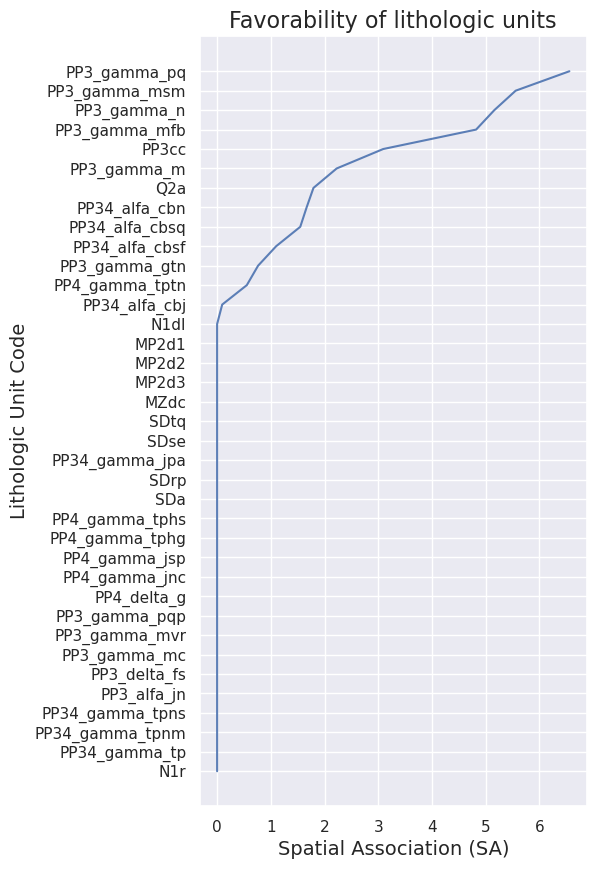

In [51]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(5, 10), facecolor='w')
plt.plot(SA, np.arange(units.size), alpha=0.9)
plt.gca().invert_yaxis()
plt.xlabel("Spatial Association (SA)", fontsize=14)
plt.ylabel("Lithologic Unit Code", fontsize=14)
plt.yticks(np.arange(units.size), labels=units, rotation=0)
plt.title('Favorability of lithologic units', fontsize=16)
plt.savefig('figs/litho_favorability.png', dpi=400, bbox_inches='tight')
plt.show()

In [50]:
# find favorability for all locations in the study area
fav_lithos = np.zeros((ny, nx))

for fav, unit in zip(SA, units):
    j, k = np.where(dset['litho_units'].data == unit)
    fav_lithos[j, k] = fav

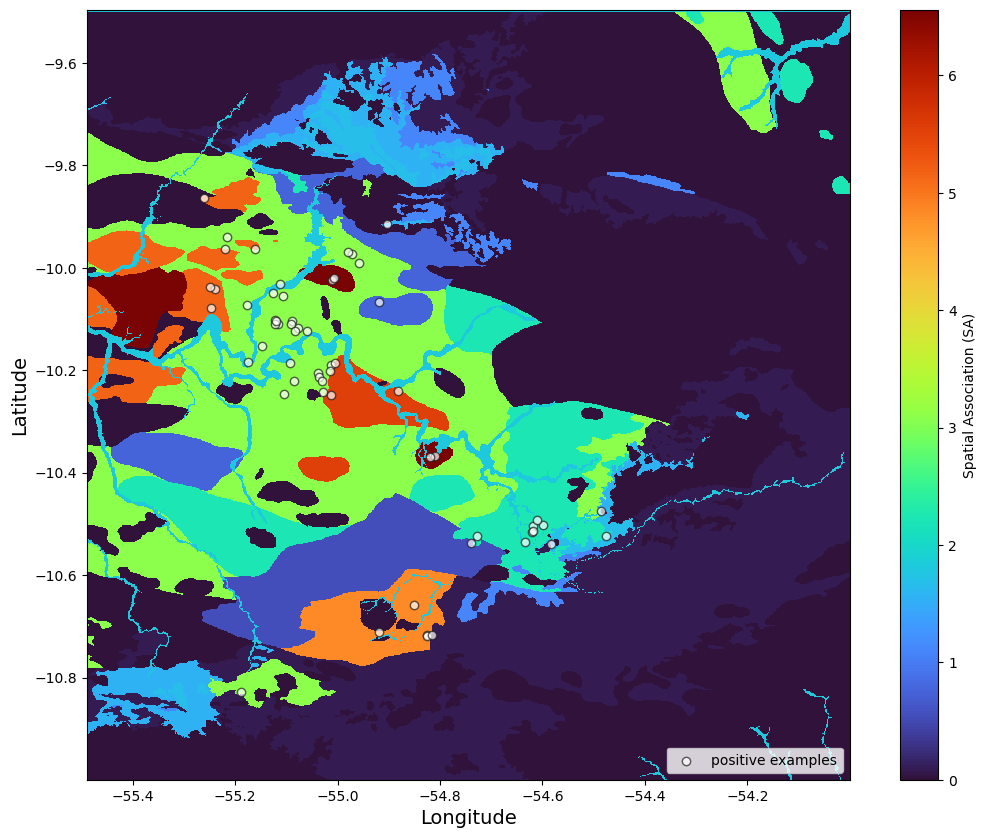

In [52]:
plt.rcParams['axes.grid'] = False
plt.style.use('default')
fig, ax = plt.subplots(figsize=(13, 10))
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, np.flip(fav_lithos, axis=0), shading='auto', cmap='turbo')
mag_epithermal.plot(ax=ax, color='w', edgecolor='k', alpha=0.7, label='positive examples')
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.colorbar(im, ax=ax, label=u'Spatial Association (SA)')
plt.legend(loc='lower right')
plt.savefig('figs/litho_favorability_map.png', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
dset['fav_lithos'] =  (['y', 'x'], np.flip(fav_lithos, axis=0),
                                             {'variable':'Favorability of lithologic units', 'unit':'dimensionless'})

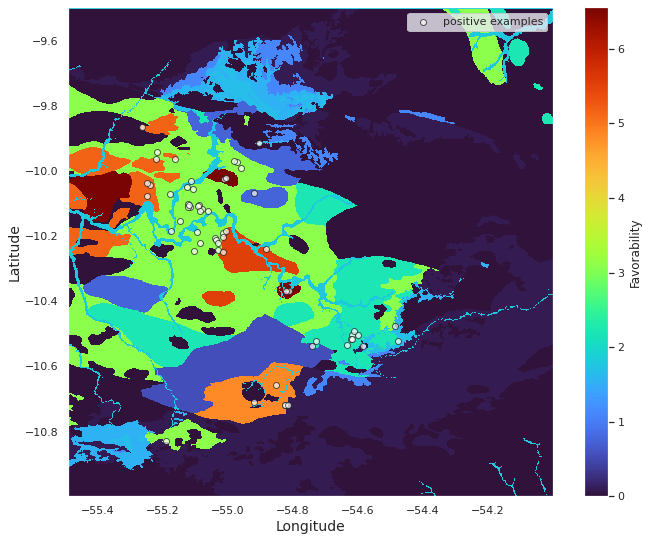

In [34]:
plt.rcParams['axes.grid'] = False
fig, ax = plt.subplots(figsize=(11, 9))
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, dset['fav_lithos'].data, shading='auto', cmap='turbo')
mag_epithermal.plot(ax=ax, color='w', edgecolor='k', alpha=0.7, label='positive examples')
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.colorbar(im, ax=ax, label=u'Favorability')
plt.legend()
#plt.savefig('figs/norm_log_likelihood.png', dpi=400, bbox_inches='tight')
plt.show()

#### Diques e estruturas/lineamentos

In [35]:
dykes_points = gpd.read_file('VETORES/dykes2points.gpkg',
                     bbox=bounds.geometry)
dykes_points.to_crs(crs, inplace=True)
print(dykes_points.shape)
dykes_points.head(3)

(2108, 54)


,rand_point_id,COD_UNI_ES,SIGLA_UNID,NMESTRUTUR,ESTRUTURA,DESCRICAO,ORIGEM,REGIME_TEC,SIGLAS_ANT,NOME_UNIDA,...,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,Presence,geometry
0,2611,6750,MP2_delta_ng,Diabásio Nova Guarita,Dique de diabásio,Diques de diabásio e microgabro de direção pre...,Nova Guarita,Extensional,None,Diabásio Nova Guarita,...,None,None,None,"Microgabro, Diabásio",None,Ígnea,None,Plutônica,NaN,POINT (-54.58005 -10.97924)
1,2608,6750,MP2_delta_ng,Diabásio Nova Guarita,Dique de diabásio,Diques de diabásio e microgabro de direção pre...,Nova Guarita,Extensional,None,Diabásio Nova Guarita,...,None,None,None,"Microgabro, Diabásio",None,Ígnea,None,Plutônica,NaN,POINT (-54.57773 -10.97994)
2,2606,6750,MP2_delta_ng,Diabásio Nova Guarita,Dique de diabásio,Diques de diabásio e microgabro de direção pre...,Nova Guarita,Extensional,None,Diabásio Nova Guarita,...,None,None,None,"Microgabro, Diabásio",None,Ígnea,None,Plutônica,NaN,POINT (-54.57331 -10.98128)


In [36]:
def calc_buffer(ds, gdf, xdim='lon', ydim='lat', n=1000, set_random=True):

    import warnings
    from numpy.random import choice
    from numpy import concatenate
    from scipy.interpolate import griddata
    from scipy.spatial.distance import euclidean
    from tqdm.notebook import tqdm
    import time
    warnings.simplefilter("ignore", UserWarning)
    
    tic = time.time()
    x = ds[xdim].data
    y = ds[ydim].data
    ny, nx = ds.dims['y'], ds.dims['x']
    print((ny, nx))
     

    if set_random:
        index = np.arange(0, y.size, 1, dtype=int)
        sy = sx = choice(index, size=int(n*.8), replace=False)
    
    else:
        sy = sx = np.arange(0, y.size, int(n*.8), dtype=int)
    
    yborder = np.linspace(0, ny-1, n//20, dtype=int)
    xborder = np.linspace(0, nx-1, n//20, dtype=int)
    xi = concatenate([x.ravel()[sx], x[0, :][xborder], x[-1, :][xborder],
                      x[:, 0][yborder], x[:,-1][yborder]])
    yi = concatenate([y.ravel()[sy], y[0, :][xborder], y[-1, :][xborder],
                      y[:, 0][yborder], y[:, -1][yborder]])
    
    # create buffer array
    buffer = np.empty(xi.size)
    
    # gdf x, y coordinates
    xp = gdf.geometry.x.values
    yp = gdf.geometry.y.values
    
    c = 0
    for x_i, y_i in zip(xi, yi):
        
        percentage = c/n
        time_msg = "\rRunning Progress at {0:.0%} ".format(percentage)
        stdout.write(time_msg)
        # store distances
        dist = []
        for x_p, y_p in zip(xp, yp):
    
            dist.append(euclidean((x_i, y_i), (x_p, y_p)))
        
        # add min distance to array
        buffer[c] = np.min(dist)
        c += 1
    
    # logistic function
    buffer = np.exp(buffer)/(1+np.exp(buffer))
    
    # normalize 
    buffer = ((buffer) - np.min(buffer))/(np.max(buffer) - np.min(buffer))
    buffer = 1 - buffer
    
    # interp
    buffer = griddata((xi, yi), buffer, (x, y), method='linear')
    toc = time.time()
    
    print(f'\n Processing Time: {(toc-tic)/60} min.')
    return buffer

In [37]:
buffer = calc_buffer(dset, dykes_points, n=50000, set_random=True)

(1335, 1322)
Running Progress at 100% 
 Processing Time: 7.4618721087773645 min.


In [38]:
dset['dykes_buffer'] =  (['y', 'x'], np.where(np.isnan(buffer) == True, 
         np.nanmean(buffer), buffer), {'variable':'Proximity to dykes', 'unit':'dimensionless'})

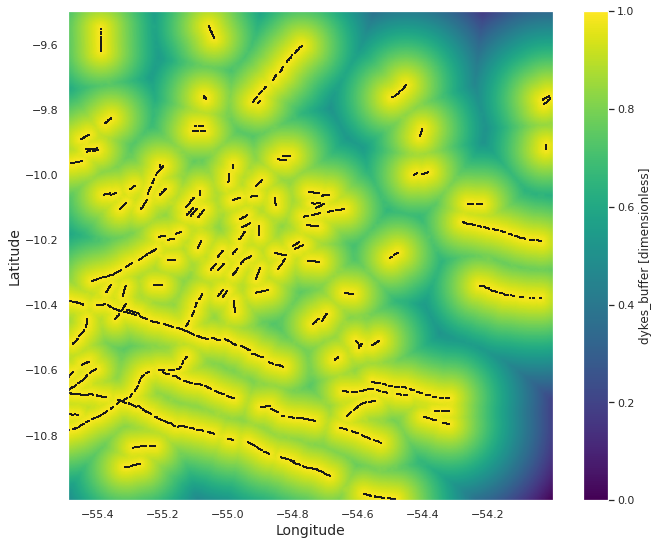

In [39]:
fig, ax = plt.subplots(figsize=(11, 9), facecolor='w')
dset['dykes_buffer'].plot(x='lon', y='lat')
dykes_points.plot(ax=ax, color='k', marker='+', markersize=5)
plt.xlim(dset['lon'].data.min(), dset['lon'].data.max())
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('figs/dykes_buffer.svg', format='svg', dpi=400, bbox_inches='tight')
plt.savefig('figs/dykes_buffer.png', dpi=400, bbox_inches='tight')
plt.show()

In [40]:
# dykes buffer at positive locations
print('min:', dset['dykes_buffer'].data[pos_idy, pos_idx].min())
print('mean:', dset['dykes_buffer'].data[pos_idy, pos_idx].mean())
print('max:', dset['dykes_buffer'].data[pos_idy, pos_idx].max())

min: 0.7366782562551866
mean: 0.934175333687673
max: 0.9919377856963838


### Structures/Lineaments

In [41]:
strucs = gpd.read_file('Juruena_Teles_Pires_Mapa_Integrado/Estrutura/Juruena_Teles_Pires_Estrutura.shp')
cond1 = strucs.ESTRUTURA == 'Lineamentos obtidos pela geofísica: Magnetometria 1° Derivada'
cond2 = strucs.ESTRUTURA == 'Lineamentos obtidos por imagem: SRTM'
cond3 = strucs.ANG_NORTE != 0
strucs = strucs[cond1 | cond2]
strucs = strucs[cond3]
strucs.reset_index(drop=True, inplace=True)
strucs.head(3)

,ESTRUTURA,ORIGEM,SENTIDO_DE,REGIME_TEC,ANG_NORTE,EXTENSAO,geometry
0,Lineamentos obtidos pela geofísica: Magnetomet...,Tapajós-Parima,None,Não-determinado,206,1.422614,"LINESTRING (-55.14911 -10.00278, -55.15474 -10..."
1,Lineamentos obtidos pela geofísica: Magnetomet...,Rondônia-Juruena,None,Não-determinado,74,0.341432,"LINESTRING (-54.61888 -10.03009, -54.61589 -10..."
2,Lineamentos obtidos pela geofísica: Magnetomet...,Tapajós-Parima,None,Não-determinado,203,2.925231,"LINESTRING (-55.15818 -10.01781, -55.16179 -10..."


In [42]:
bin_edges = np.arange(-5, 366, 10)
number_of_strikes, bin_edges = np.histogram(strucs.ANG_NORTE.values, bin_edges)
number_of_strikes[0] += number_of_strikes[-1]
half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
two_halves = np.concatenate([half, half])

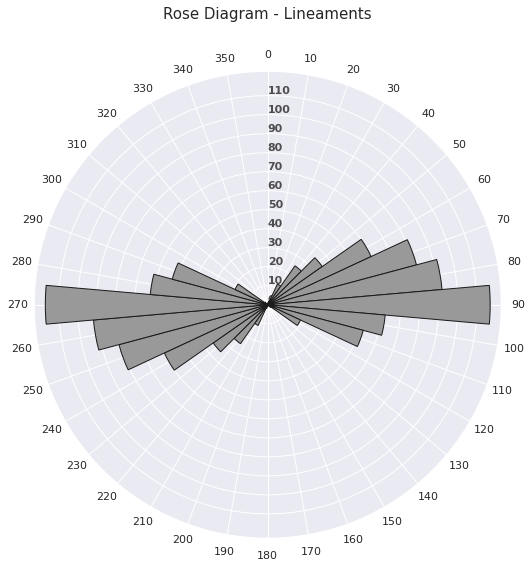

In [43]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(projection='polar')
ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves, 
       width=np.deg2rad(10), bottom=0.0, color='.6', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
ax.set_rgrids(np.around(np.arange(1, two_halves.max() + 1, 10), -1), angle=0, weight='black', alpha=0.8)
ax.set_title('Rose Diagram - Lineaments', y=1.10, fontsize=15)

fig.tight_layout()

### Points

In [44]:
lineam = gpd.read_file('VETORES/struc2points.gpkg',
                     bbox=bounds.geometry)
lineam.to_crs(crs, inplace=True)
cond1 = lineam.ESTRUTURA == 'Lineamentos obtidos pela geofísica: Magnetometria 1° Derivada'
cond2 = lineam.ESTRUTURA == 'Lineamentos obtidos por imagem: SRTM'
cond3 = lineam.ANG_NORTE != 0
lineam = lineam[cond1 | cond2]
lineam = lineam[cond3]
lineam.reset_index(drop=True, inplace=True)

print(lineam.shape)
lineam.head(3)

(9619, 8)


,rand_point_id,ESTRUTURA,ORIGEM,SENTIDO_DE,REGIME_TEC,ANG_NORTE,EXTENSAO,geometry
0,24252,Lineamentos obtidos pela geofísica: Magnetomet...,Rondônia-Juruena,None,Não-determinado,90,5.834214,POINT (-54.94290 -10.96595)
1,24241,Lineamentos obtidos pela geofísica: Magnetomet...,Rondônia-Juruena,None,Não-determinado,91,5.541262,POINT (-54.94771 -10.93766)
2,24244,Lineamentos obtidos pela geofísica: Magnetomet...,Rondônia-Juruena,None,Não-determinado,91,5.541262,POINT (-54.95042 -10.93750)


In [45]:
# WNW-ESE ~ W-E
cond1 = (lineam.ANG_NORTE >= 260) & (lineam.ANG_NORTE <= 280)
cond2 = (lineam.ANG_NORTE > 80) & (lineam.ANG_NORTE <= 110)


# NE-SW
cond3 = (lineam.ANG_NORTE <= 80) 
cond4 = (lineam.ANG_NORTE > 180) & (lineam.ANG_NORTE < 260)

# create sub-dfs
lineam_wnw_ese = lineam[cond1 | cond2].copy()
lineam_wnw_ese.reset_index(drop=True, inplace=True)

lineam_ne_sw = lineam[cond3 | cond4].copy()
lineam_ne_sw.reset_index(drop=True, inplace=True)

In [46]:
print(lineam_wnw_ese.shape)
print(lineam_wnw_ese.ANG_NORTE.unique())

(3486, 8)
[ 90  91  86  82  84 100  85  87  89 102  97  88  94  83  92  81 110 104
  96 101  93  95 105  99 107 103 106  98 109]


In [47]:
print(lineam_ne_sw.shape)
print(np.sort(lineam_ne_sw.ANG_NORTE.unique()))

(5647, 8)
[ 15  26  28  29  31  32  33  34  35  36  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  54  55  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 203 206
 207 209 221 226]


In [48]:
buffer_struc_wnw_ese = calc_buffer(dset, lineam_wnw_ese, n=50000, set_random=True)

(1335, 1322)
Running Progress at 100% 
 Processing Time: 12.275333877404531 min.


In [49]:
buffer_struc_ne_sw = calc_buffer(dset, lineam_ne_sw, n=50000, set_random=True)

(1335, 1322)
Running Progress at 100% 
 Processing Time: 19.826532578468324 min.


In [50]:
dset['lineam_ne_sw_proxim'] =  (['y', 'x'], np.where(np.isnan(buffer_struc_ne_sw) == True, 
         np.nanmean(buffer_struc_ne_sw), buffer_struc_ne_sw), {'variable':'Proximity to dykes', 'unit':'dimensionless'})
dset['lineam_wnw_ese_proxim'] =  (['y', 'x'], np.where(np.isnan(buffer_struc_wnw_ese) == True, 
         np.nanmean(buffer_struc_wnw_ese), buffer_struc_wnw_ese), {'variable':'Proximity to dykes', 'unit':'dimensionless'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/14)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    litho_units            (y, x) object 'Q2a' 'Q2a' 'Q2a' ... 'N1r' 'N1r' 'N1r'
    labels                 (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fav_lithos             (y, x) float64 0.0 0.0 0.0 0.0 ... 1.794 1.794 1.794
    dykes_buffer           (y, x) float64 0.4874 0.4899 0.4923 ... 0.3356 0.3354
    lineam_ne_sw_proxim    (y, x) float64 0.3951 0.3981 0.4011 ... 0.9581 0.9568
    lineam_wnw_ese_proxim  (y, x) float64 0.3506 0.3519 0.3533 ... 0.002598 0.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [51]:
# save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF_3.nc', mode='w', format='NETCDF4')
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/14)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    litho_units            (y, x) object 'Q2a' 'Q2a' 'Q2a' ... 'N1r' 'N1r' 'N1r'
    labels                 (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fav_lithos             (y, x) float64 0.0 0.0 0.0 0.0 ... 1.794 1.794 1.794
    dykes_buffer           (y, x) float64 0.4874 0.4899 0.4923 ... 0.3356 0.3354
    lineam_ne_sw_proxim    (y, x) float64 0.3951 0.3981 0.4011 ... 0.9581 0.9568
    lineam_wnw_ese_proxim  (y, x) float64 0.3506 0.3519 0.3533 ... 0.002598 0.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [52]:
def export_tif(ds, crs, path):

    import rasterio
    import rioxarray
    import warnings
    warnings.simplefilter("ignore", UserWarning)
    ds.rio.set_crs(crs, inplace=True)
    ds.rio.to_raster(path, driver='GTiff')
    
    x = ds['lon'].data
    y = ds['lat'].data
    src = rasterio.open(path)
    # get meta dict
    meta = src.meta

    # calculate pixel size
    pixel_size = np.diff(x).min()

    # add new affine
    meta['transform'] = rasterio.Affine(float(pixel_size), float(0.0), x.min(),
                    0.0, float(-pixel_size), float(y.max()))

    # export to tiff
    with rasterio.open(path, 'w', **meta) as raster:
        # If array is in  (y, x, z) order (cols, rows, bands)
        source = np.flip(src.read(), axis=1)
        raster.write(source)

In [53]:
export_tif(dset[['TC', 'Kperc', 'eTh', 'eU',
                 'resmag', 'asa', 'tilt', 'DTM']], "epsg:4674", 'RASTERS/geoscientific_data2.tiff')

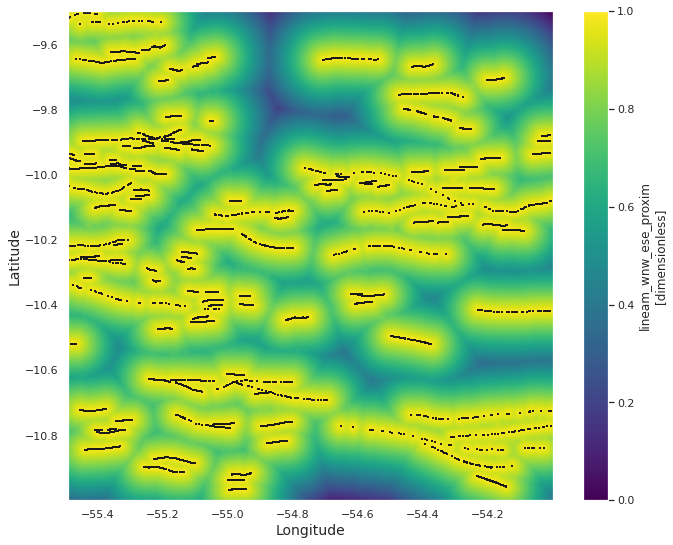

In [54]:
fig, ax = plt.subplots(figsize=(11, 9), facecolor='w')
dset['lineam_wnw_ese_proxim'].plot(x='lon', y='lat')
lineam_wnw_ese.plot(ax=ax, color='k', marker='+', markersize=5)
plt.xlim(dset['lon'].data.min(), dset['lon'].data.max())
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('figs/lineam_wnw_ese_buffer.svg', format='svg', dpi=400, bbox_inches='tight')
# plt.savefig('figs/lineam_wnw_ese_buffer.png', dpi=400, bbox_inches='tight')
plt.show()

In [55]:
# dykes buffer at positive locations
print('min:', dset['lineam_wnw_ese_proxim'].data[pos_idy, pos_idx].min())
print('mean:', dset['lineam_wnw_ese_proxim'].data[pos_idy, pos_idx].mean())
print('max:', dset['lineam_wnw_ese_proxim'].data[pos_idy, pos_idx].max())

min: 0.41804963217782326
mean: 0.768962033522144
max: 0.9740023991006725


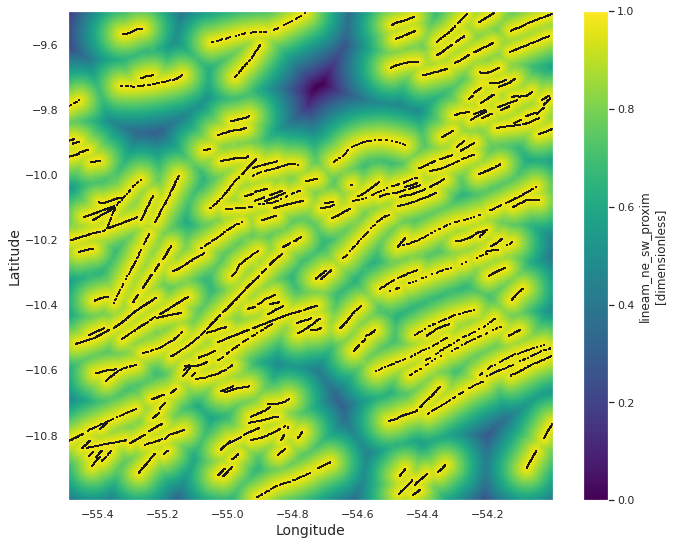

In [56]:
fig, ax = plt.subplots(figsize=(11, 9), facecolor='w')
dset['lineam_ne_sw_proxim'].plot(x='lon', y='lat')
lineam_ne_sw.plot(ax=ax, color='k', marker='+', markersize=5)
plt.xlim(dset['lon'].data.min(), dset['lon'].data.max())
ax.set_aspect(1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.savefig('figs/lineam_ne_sw_buffer.svg', format='svg', dpi=400, bbox_inches='tight')
#plt.savefig('figs/lineam_ne_sw_buffer.png', dpi=400, bbox_inches='tight')
plt.show()

In [57]:
# dykes buffer at positive locations
print('min:', dset['lineam_ne_sw_proxim'].data[pos_idy, pos_idx].min())
print('mean:', dset['lineam_ne_sw_proxim'].data[pos_idy, pos_idx].mean())
print('max:', dset['lineam_ne_sw_proxim'].data[pos_idy, pos_idx].max())

min: 0.3577670840458393
mean: 0.8361003139647283
max: 0.980215819190418


In [58]:
variables = [var for var in dset.data_vars]
print(variables)

['TC', 'Kperc', 'eTh', 'eU', 'resmag', 'asa', 'tilt', 'DTM', 'litho_units', 'labels', 'fav_lithos', 'dykes_buffer', 'lineam_ne_sw_proxim', 'lineam_wnw_ese_proxim']
